In [1]:
import time
import os
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from IPython import display

from dataset import MultiscaleDataset
from gen_video import gen_video

In [2]:
train_set = MultiscaleDataset('../public/data/lego', 'blender',
        partition='train')
val_set = MultiscaleDataset('../public/data/lego', 'blender',
        partition='val')
H, W = train_set.H, train_set.W

Camera position mean & std:
[ -1.9723758  -11.407406     0.36299774] [10.950828   5.4356313 11.073948 ]
Camera position mean & std:
[ -0.97222143 -11.682014     0.6100528 ] [10.584989   5.2982874 11.329139 ]


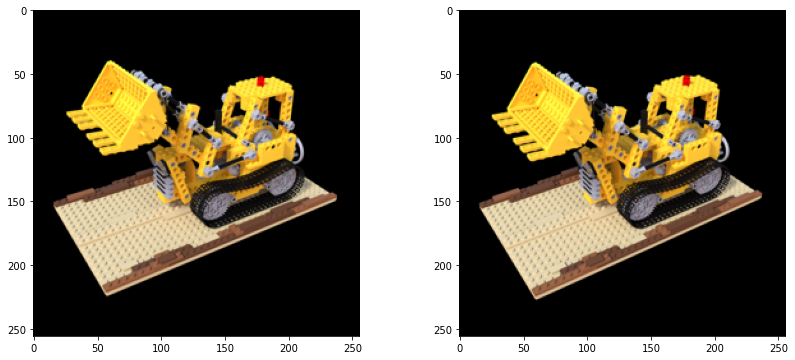

In [3]:
train_id = 68
val_id = 24

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.imshow(train_set.images[train_id].permute(1,2,0))
plt.subplot(122)
plt.imshow(val_set.images[val_id].permute(1,2,0))
plt.show()

In [4]:
# todo: use either 2, 3 for both
def ray_box_intersection(rays, bounds, zero_miss=True):
    """Find intersection of rays with a box
    
    Args:
        rays: Tensor with shape [None, 6]. Each row should be
            [x, y, z, dx, dy, dz]
        bounds: Tensor with shape [3, 2] or [None, 3, 2] representing
            min and max coords of the box on each axis
        zero_miss: Set coords to 0 for missed rays
    
    Returns shape [None, 2, 3] tensor with nearest and furthest
        intersection coords rescaled to [0, 1]
        and a shape [None,] hit mask
    """
    ro = rays[:, :3]
    rd = rays[:, 3:]
    if bounds.dim() == 2:
        bounds_expanded = bounds.unsqueeze(0).expand(rays.shape[0], 3, 2)
    else:
        bounds_expanded = bounds
    signs = (rd < 0).long().unsqueeze(-1)
    near_bounds = bounds_expanded.gather(-1, signs).squeeze(-1)
    t_near = ((near_bounds - ro) / rd).max(dim=-1)[0]
    far_bounds = bounds_expanded.gather(-1, 1 - signs).squeeze(-1)
    t_far = ((far_bounds - ro) / rd).min(dim=-1)[0]
    pts = torch.stack([
        ro + rd * t_near.unsqueeze(-1),
        ro + rd * t_far.unsqueeze(-1)
    ], dim=1)
    bounds_range = (bounds_expanded[:, :, 1] - bounds_expanded[:, :, 0]).unsqueeze(1).expand(pts.shape)
    pts_rescaled = (pts - bounds_expanded[:, :, 0].unsqueeze(1).expand(pts.shape)) / bounds_range
    hit_mask = t_near < t_far
    if zero_miss:
        pts_rescaled[~hit_mask] = 0
    return pts_rescaled, hit_mask

In [5]:
def raymarch(model, ro, rd, s, res, net=None):
    """Raymarch through a voxel volume
    
    Args:
        model: obj with voxel_fn(), that predicts [r, g, b, density] from 9D input (voxel xyz, 6D localized ray encoding) 
        ro: Normalized ray origins with shape [None, 3]. Origins should be in the range [0, 1]
        rd: Ray directions with shape [None, 3]
        s: pixel size (todo: cone angle)
        res: Resolution tensor with shape [3,]
        net: optionally use a network other than model's default (used for MLDG training)
    
    Returns a [None, 3] tensor containing accumulated RGB for each ray
    """
    # initialization
    ro = ro * res
    X = ro.clamp(torch.zeros(3, device='cuda'), res - 1).long()
    step = rd.sign().long()
    t_delta = (1 / rd).abs()
    t_max = (X + (step * 0.5 + 0.5) - ro).abs() * t_delta
    acc_density = torch.zeros_like(ro[:, :1])
    rgb = torch.zeros_like(ro)
    active = torch.arange(ro.shape[0], device='cuda').long()
    
    res = res[None, :]
    while active.shape[0] != 0:
        roa = ro[active]
        rda = rd[active]
        voxel_coords = X[active] + 0.5
        # get localized ray
        ro_to_vox = voxel_coords - roa
        t = (ro_to_vox * rda).sum(dim=-1, keepdim=True)
        local_ro = roa + rda * t
        local_ro = (local_ro - voxel_coords) * 2
        local_rays = torch.cat([voxel_coords * 2 / res - 1, local_ro, rda], dim=-1)
        local_rays = torch.cat([(roa + rda * t) * 2 / res - 1, rda], dim=-1)
        
        # x_near_corner = X[active] + (-step[active] * 0.5 + 0.5)
        # x2_near_corner = x_near_corner.clone()
        # x2_near_corner[torch.arange(x2_near_corner.shape[0]), step_axis] += step[active, step_axis]
        # ray_t1 = ((x_near_corner - roa).abs() * t_delta[active]).min(dim=-1, keepdim=True)[0]
        # ray_t2 = ((x2_near_corner - roa).abs() * t_delta[active]).min(dim=-1, keepdim=True)[0]
        
        # compute intersection lengths
        #x_near_corner = X[active] + (-step[active] * 0.5 + 0.5)
        #bds = torch.stack([X[active], X[active] + 1], axis=-1)
        bds = torch.tensor([[-1, 1] for _ in range(3)], device='cuda')
        #print(bds.shape)
        pts, hit = ray_box_intersection(torch.cat([local_ro, rda], axis=-1), bds)
        #print(((pts[:, 1] - pts[:, 0]) * rda).sum(dim=-1))
        #print(hit.shape, hit.int().sum())
        int_len = torch.linalg.vector_norm(pts[:, 1] - pts[:, 0], dim=-1, keepdim=True)
        #print(local_ro.min(), local_ro.max(), int_len.min(), int_len.max())
        
        # accumulate color and density
        vi = model.voxel_fn(torch.cat([local_rays, s[active]], dim=-1))
        density = vi[:, 3, None].relu() # no negative density
        #density = torch.tensor([2], device='cuda')
        # multiply by voxel intersection length
        density = density * int_len
        alpha = 1 - torch.exp(-density)
        transmittance = torch.exp(-acc_density[active])
        rgb[active] += vi[:, :3] * alpha * transmittance
        acc_density[active] += density
        
        # step X to next voxel
        step_axis = t_max[active].min(dim=-1)[1]
        X[active, step_axis] += step[active, step_axis]
        t_max[active, step_axis] += t_delta[active, step_axis]
        
        # deactivate if stepped outside bounds
        active_mask = (X[active] >= 0).all(dim=-1).logical_and((X[active] < res).all(dim=-1))
        active = active[active_mask]
    
    return rgb

In [37]:
# https://davidlindell.com/publications/bacon

class Bacon(nn.Module):
    def __init__(self, in_feats=7, hidden_feats=256, out_feats=4,
                 res=8, n_layers=4):
        super().__init__()
        
        if (n_layers < 2):
            n_layers = 2
            print("min layers: 2")
        
        self.in_feats = in_feats
        self.hidden_feats = hidden_feats
        self.out_feats = out_feats
        self.res = res
        self.n_layers = n_layers
        
        # omega/phi
        # using tensors for gw instead of parameters with no grad (for mldg implementation)
        gw = [torch.empty(in_feats, hidden_feats, device='cuda') \
                 for _ in range(n_layers + 1)]
        gb = nn.ParameterList([nn.Parameter(torch.rand(hidden_feats, requires_grad=True))
                               for _ in range(n_layers + 1)])
        
        zwb = [nn.Linear(hidden_feats, hidden_feats) \
              for _ in range(n_layers)]
        ywb = [nn.Linear(hidden_feats, out_feats) \
               for _ in range(n_layers)]
        
        # max bandwidth
        total_B = np.pi * res
        # first 2 tb/8, rest set to sum to tb
        B = [total_B / 8] * 2
        B += [total_B * 3 / 4 / (n_layers - 1)] * (n_layers - 1)
        
        nn.init.uniform_(gw[0], -B[0], B[0])
        nn.init.uniform_(gb[0], -np.pi, np.pi)
        for i, (lgw, lgb, lz, ly) in enumerate(zip(gw[1:], gb[1:], zwb, ywb)):
            nn.init.uniform_(lgw, -B[i + 1], B[i + 1])
            nn.init.uniform_(lgb, -np.pi, np.pi)
            nn.init.uniform_(lz.weight, -np.sqrt(6 / hidden_feats),
                             np.sqrt(6 / hidden_feats))
        
        self.gw = gw
        self.gb = gb
        self.zwb = nn.ModuleList(zwb)
        self.ywb = nn.ModuleList(ywb)
    
    # todo: train with last_only=False
    def forward(self, x, last_only=True):
        x = x.clone()
        x[:, -1] /= self.res / 4
        y = []
        g = torch.sin(x @ self.gw[0] + self.gb[0])
        for i in range(self.n_layers):
            z = torch.sin(x @ self.gw[i + 1] + self.gb[i + 1])
            z = g * self.zwb[i](z)
            y.append(self.ywb[i](z))
        
        return y[-1] if last_only else y

mse = nn.MSELoss()
def loss_fn(output, target):
    if type(output) is list:
        return sum([mse(v, target) for v in output]) / len(output)
    else:
        return mse(output, target)

In [38]:
# https://arxiv.org/pdf/1710.03463.pdf - Learning to Generalize: Meta-Learning for Domain Generalization
# https://github.com/facebookresearch/DomainBed/blob/main/domainbed/algorithms.py#L477

from itertools import cycle
import copy
import torch.nn.functional as F
from torch import autograd
import higher

class RayMLDG(nn.Module):
    """
    Model-Agnostic Meta-Learning
    Algorithm 1 / Equation (3) from: https://arxiv.org/pdf/1710.03463.pdf
    Related: https://arxiv.org/pdf/1703.03400.pdf
    Related: https://arxiv.org/pdf/1910.13580.pdf
    """
    def __init__(self, hparams):
        super().__init__()
        
        self.scene_bds = torch.tensor([
            [-2, 2], [-2.5, 1.5], [-2.5, 1.5]
        ], device='cuda').float() * 2.5
        self.voxel_res = torch.ones(3, device='cuda') * 2
        
        self.hparams = hparams
        self.num_meta_test = hparams['n_meta_test']
        
        self.network = Bacon()
        self.optimizer = torch.optim.Adam(
            self.network.parameters(),
            lr=self.hparams["lr"],
            weight_decay=self.hparams['weight_decay']
        )
    
    def voxel_fn(self, x, net=None):
        h = x.clone()
        #h[:, :3] *= 5
        if net is None:
            net = self.network
        return net(x)
    
    # minibatches format is different here
    def update(self, minibatches, first_order=True):
        """
        Terms being computed:
            * Li = Loss(xi, yi, params)
            * Gi = Grad(Li, params)
            * Lj = Loss(xj, yj, Optimizer(params, grad(Li, params)))
            * Gj = Grad(Lj, params)
            * params = Optimizer(params, Grad(Li + beta * Lj, params))
            *        = Optimizer(params, Gi + beta * Gj)
        That is, when calling .step(), we want grads to be Gi + beta * Gj
        For computational efficiency, we do not compute second derivatives.
        """
        if first_order:
            num_mb = len(minibatches) # 2
            objective = 0
            
            self.optimizer.zero_grad()
            for p in self.network.parameters():
                if p.grad is None:
                    p.grad = torch.zeros_like(p)
            
            ## single task
            [(xi, yi), (xj, yj)] = minibatches
            
            # fine tune clone-network on task "i"
            inner_net = copy.deepcopy(self.network)
            
            inner_opt = torch.optim.Adam(
                inner_net.parameters(),
                lr=self.hparams['lr'],
                weight_decay=self.hparams['weight_decay']
            )
            
            # changed from cross_entropy
            inner_obj = loss_fn(self.forward(xi, inner_net), yi)
            
            inner_opt.zero_grad()
            inner_obj.backward()
            inner_opt.step()
            
            # The network has now accumulated gradients Gi
            # The clone-network has now parameters P - lr * Gi
            for p_tgt, p_src in zip(self.network.parameters(),
                                    inner_net.parameters()):
                if p_src.grad is not None:
                    p_tgt.grad.data.add_(p_src.grad.data / num_mb)
            
            # `objective` is populated for reporting purposes
            objective += inner_obj.item()
            
            # this computes Gj on the clone-network
            loss_inner_j = loss_fn(self.forward(xj, inner_net), yj)
            grad_inner_j = autograd.grad(loss_inner_j, inner_net.parameters(),
                allow_unused=True)

            # `objective` is populated for reporting purposes
            objective += (self.hparams['mldg_beta'] * loss_inner_j).item()

            for p, g_j in zip(self.network.parameters(), grad_inner_j):
                if g_j is not None:
                    p.grad.data.add_(
                        self.hparams['mldg_beta'] * g_j.data / num_mb)
            
            # The network has now accumulated gradients Gi + beta * Gj
            # Repeat for all train-test splits, do .step()
            
            ## end single task
            
            objective /= num_mb
            
            self.optimizer.step()
            
            return {'loss': objective}
        else:
            # This commented "update" method back-propagates through the gradients of
            # the inner update, as suggested in the original MAML paper.  However, this
            # is twice as expensive as the uncommented "update" method, which does not
            # compute second-order derivatives, implementing the First-Order MAML
            # method (FOMAML) described in the original MAML paper.
            objective = 0
            beta = self.hparams['mldg_beta']
            #inner_iterations = self.hparams['inner_iterations']
            inner_iterations = 1
            
            self.optimizer.zero_grad()
            
            with higher.innerloop_ctx(self.network, self.optimizer,
                copy_initial_weights=False) as (inner_network, inner_optimizer):
                
                ## single task
                [(xi, yi), (xj, yj)] = minibatches
                for inner_iteration in range(inner_iterations):
                    li = loss_fn(self.forward(xi, inner_network), yi)
                    inner_optimizer.step(li)
                    
                objective += loss_fn(self.forward(xi, self.network), yi)
                objective += beta * loss_fn(self.forward(xj, inner_network), yj)
                # end single task
                
                objective /= len(minibatches)
                objective.backward()
                
            self.optimizer.step()
            
            return {'loss': objective.item()}
    
    def forward(self, rays, net=None):
        pts, hit_mask = ray_box_intersection(rays[..., :6], self.scene_bds)
        ptsfar = pts[:, 1]
        pts = pts[:, 0]
        rgb = torch.zeros_like(pts)
        rgb[hit_mask] = raymarch(self, pts[hit_mask], rays[hit_mask, 3:6],
                                 rays[hit_mask, 6:7], self.voxel_res, net)
        return rgb

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = int(2e4)
# lr is for both inner and outer (alpha and gamma)
model = RayMLDG({
    'lr': 5e-4, 'weight_decay': 0., 'mldg_beta': 1.,
    'n_meta_test': batch_size // 2
})
model.to(device)

train_losses = np.array([])
val_losses = np.array([])

1000/1000
1m7s - eta 0s


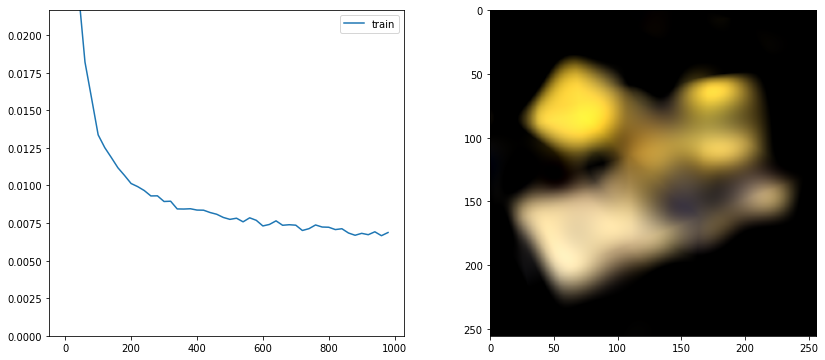

training loss: 0.0071060369489714505


In [40]:
train_st = time.time()
time_to_s = lambda t: (f'{int(t / 60)}m' if t >= 60 else '') + f'{int(t) % 60}s'

train_loss_freq = 20
val_loss_freq = 50
display_freq = 100
save_freq = 1000

batch_size = int(5e4)
val_batch_size = int(1e4)

n_iter = int(1e3)
#n_iter = int(1e9)

while True:
    model_id = 'tmp_' + str(np.random.randint(1e6))
    if model_id not in os.listdir('models'):
        break
os.makedirs(f'models/{model_id}')

for i in range(n_iter):
    sel = np.random.choice(train_set.rays.shape[0], batch_size)
    pix_sizes = torch.pow(2, 8 * torch.rand(batch_size, 1, device='cuda')) / 256
    x = torch.cat([train_set.rays[sel], pix_sizes], dim=-1)
    
    ray_ids = torch.tensor(sel).cuda()
    idxy = train_set.idxy_from_ray_ids(ray_ids)
    idsxy = torch.cat([idxy[:,:1], pix_sizes, idxy[:,1:]], dim=-1)
    rgb = train_set.sample(idsxy.reshape(1, 1, sel.shape[0], 4))[0]
    rgb = rgb.permute(1, 2, 0)[0]
    
    minibatch = [(x[:len(x)//2], rgb[:len(x)//2]),
                 (x[len(x)//2:], rgb[len(x)//2:])]
    step_vals = model.update(minibatch)
    
    if (i + 1) % train_loss_freq == 0:
        train_losses = np.append(train_losses, step_vals['loss'])
    if (i + 1) % val_loss_freq == 0:
        pass
#         with torch.no_grad():
#             #sel = np.random.choice(val_set.rays.shape[0], val_batch_size)
#             #pred = model(val_set.rays[sel])
#             #mse_loss = mse_loss_fn(pred, val_set.colors[sel])
#             #val_mse_losses.append(mse_loss.item())
            
#             sel = np.random.choice(val_set.rays.shape[0], val_batch_size)
#             pix_sizes = torch.pow(2, 8 * torch.rand(val_batch_size)) / 256
#             pix_sizes = pix_sizes[..., None].cuda()
#             x = torch.cat([val_set.rays[sel], pix_sizes], dim=-1)
            
#             ray_ids = torch.tensor(sel).cuda()
#             idxy = val_set.idxy_from_ray_ids(ray_ids)
#             idsxy = torch.cat([idxy[:,:1], pix_sizes, idxy[:,1:]], dim=-1)
#             rgb = val_set.sample(idsxy.reshape(1, 1, sel.shape[0], 4))[0]
#             rgb = rgb.permute(1, 2, 0)[0]
            
#             pred = model(x)
#             mse_loss = mse_loss_fn(pred, rgb)
#             val_mse_losses.append(mse_loss.item())
    if (i + 1) % display_freq == 0:
        display.clear_output(wait=True)
        print(f'{i+1}/{n_iter}')
        time_passed = time.time() - train_st
        eta = time_passed * (n_iter - i) / i
        print(f'{time_to_s(time_passed)} - eta {time_to_s(eta)}')
        plt.figure(figsize=(14, 6))
        plt.subplot(121)
        plt.plot(np.arange(len(train_losses)) * train_loss_freq,
                 train_losses, label='train')
        plt.ylim([0, train_losses[-len(train_losses)//2:].mean() * 3])
        plt.legend()
        plt.subplot(122)
        with torch.no_grad():
            sel = torch.arange(train_id * H * W, (train_id + 1) * H * W).cuda()
            pix_sizes = torch.zeros(H * W, 1).cuda()
            x = torch.cat([train_set.rays[sel], pix_sizes], dim=-1)
            #pred = gen_batched_img(model,
            #    train_set.rays[train_id * H * W : (train_id + 1) * H * W], batch_size)
            pred = model(x)
            plt.imshow(pred.detach().clip(0,1).reshape(H, W, 3).cpu())
        plt.show()
        print(f'training loss: {np.mean(train_losses[-train_loss_freq:])}')
    if (i + 1) % save_freq == 0:
        #scheduler.step()
        torch.save(model, f'models/{model_id}/model_{model_id}.pt')
        pass

In [41]:
gen_video(train_set, model, 'videos/metagen.mp4', batch_size=256**2)
display.clear_output()
display.display(display.HTML('<video src="videos/metagen.mp4" controls=true autoplay=true loop=true />'))